In [65]:


import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import learning_curve
matplotlib.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [23]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [24]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [25]:
cursor.execute('Select * from "ahshouseholdclass2"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

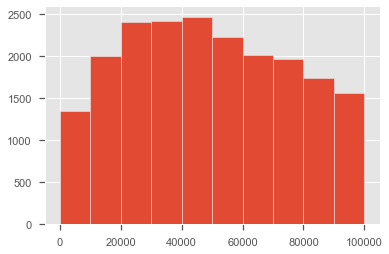

In [26]:
df['HINCP'].hist()

In [27]:
df['RATINGHS_BIN'].value_counts()

extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

### Class Imbalanced

In [42]:
X = df[['HHAGE', 'HINCP', 'BATHROOMS', 'UTILAMT','PERPOVLVL', 'ELECAMT', 'GASAMT', 'TRASHAMT', 'WATERAMT', 'OMB13CBSA','UNITSIZE','NUMPEOPLE','STORIES', 'HHNATVTY']]
y = df['RATINGHS_BIN']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c216c70f0>,
      dtype=object)

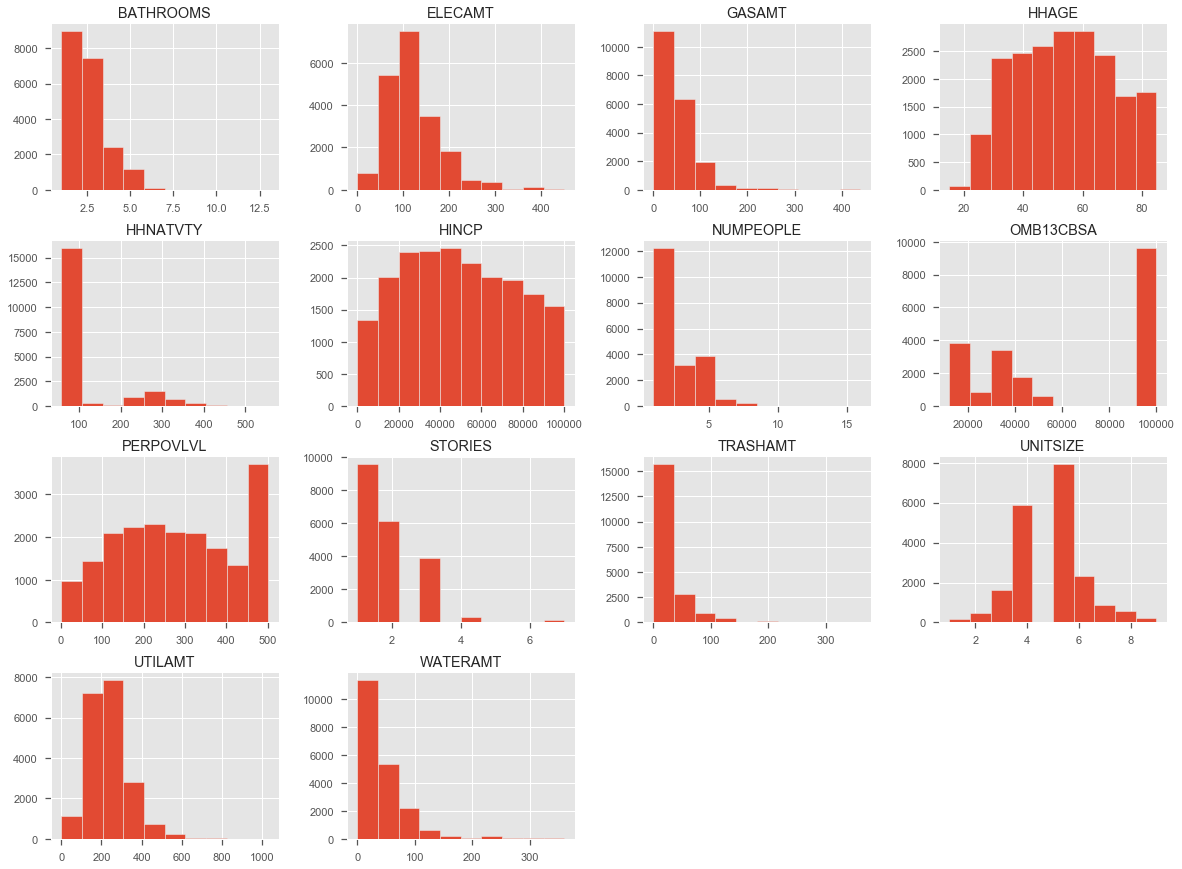

In [43]:
X.hist(figsize=(20,15))

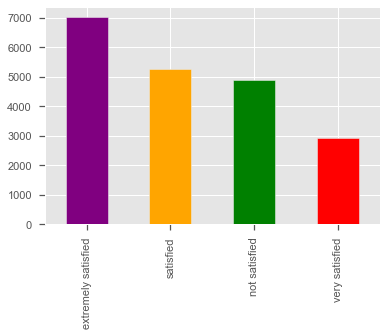

In [44]:
pd.Series(y).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

In [45]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


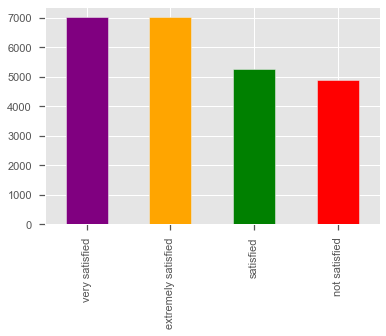

In [46]:
X_sm, y_sm = sm.fit_sample(X, y.ravel())
pd.Series(y_sm).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


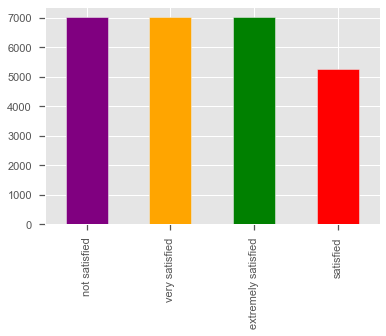

In [47]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


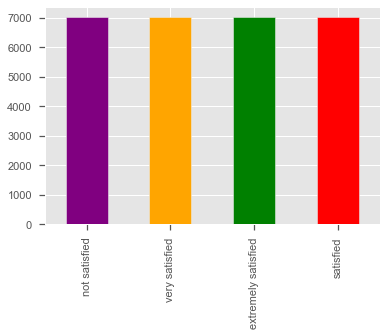

In [48]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

Precision: It is implied as the measure of the correctly identified positive cases from all the predicted positive cases. Thus, it is useful when the costs of False Positives is high.

Recall: It is the measure of the correctly identified positive cases from all the actual positive cases. It is important when the cost of False Negatives is high.

Accuracy: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.


In [49]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2)

In [50]:
from sklearn import metrics
def score_model(X, y, estimator, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])


    model.fit(X_train, y_train.ravel(), **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))
  #  print("{} Accuracy Score: {}".format(estimator.__class__.__name__, metrics.accuracy_score(expected, predicted)))

In [51]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    ExtraTreesClassifier(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

SVC: 0.24586077977568097
NuSVC: 0.3695923090617767
LinearSVC: 0.3735089905643582
SGDClassifier: 0.3911340573259747
KNeighborsClassifier: 0.33630051628983443
ExtraTreesClassifier: 0.3647854726722449
RandomForestClassifier: 0.36140288410183374
DecisionTreeClassifier: 0.3354103614028841
AdaBoostClassifier: 0.38632722093644295
GradientBoostingClassifier: 0.38632722093644295


## Classification Report

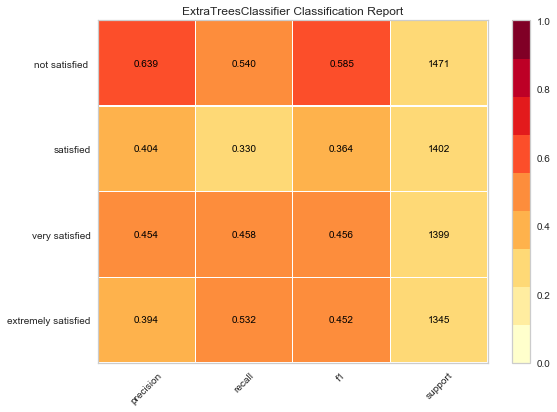

In [53]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
classes=['extremely satisfied','very satisfied','satisfied','not satisfied ']
model = ExtraTreesClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

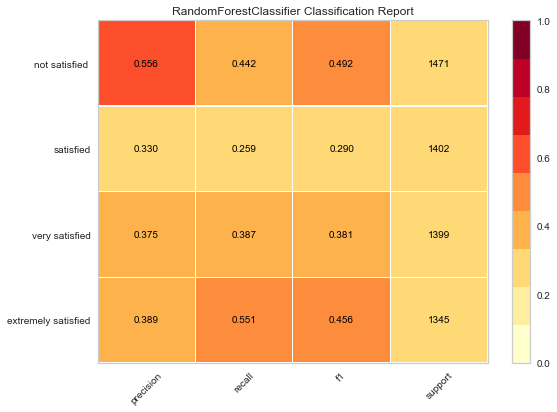

In [54]:

# Instantiate the classification model and visualizer
classes=['extremely satisfied','very satisfied','satisfied','not satisfied ']
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

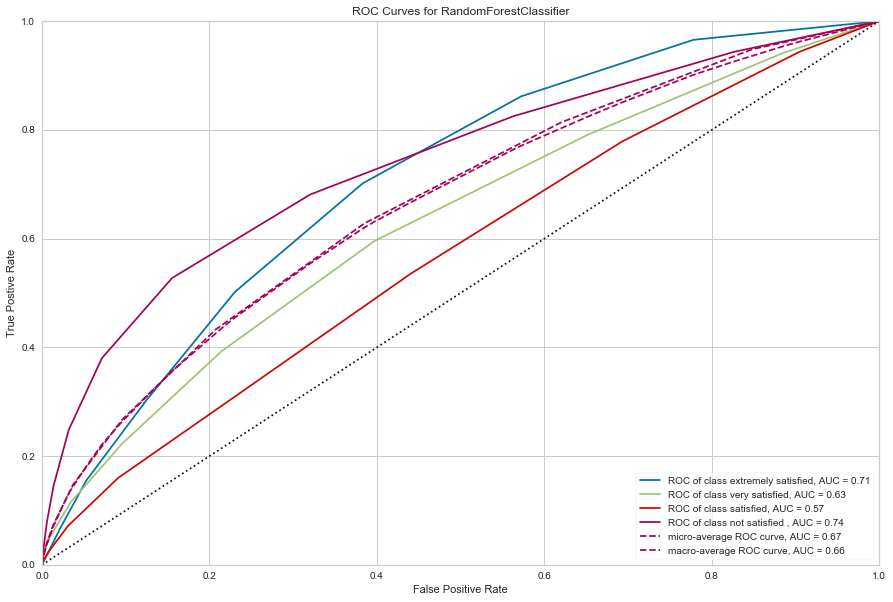

In [55]:
from yellowbrick.classifier import ROCAUC
classes=['extremely satisfied','very satisfied','satisfied','not satisfied ']

visualizer = ROCAUC(
    RandomForestClassifier(), classes=classes, size=(1080, 720)
)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

### Confusion Matrixs


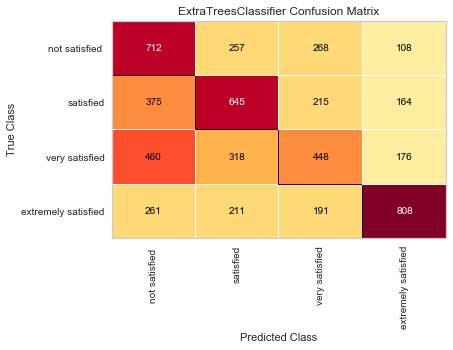

In [58]:
from yellowbrick.classifier import ConfusionMatrix
model = ExtraTreesClassifier()

cm = ConfusionMatrix(model, classes=['not satisfied ','satisfied','very satisfied','extremely satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

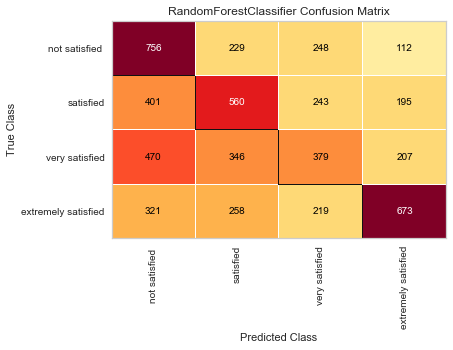

In [60]:
model = RandomForestClassifier()

cm = ConfusionMatrix(model, classes=['not satisfied ','satisfied','very satisfied','extremely satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

### Cross Validation

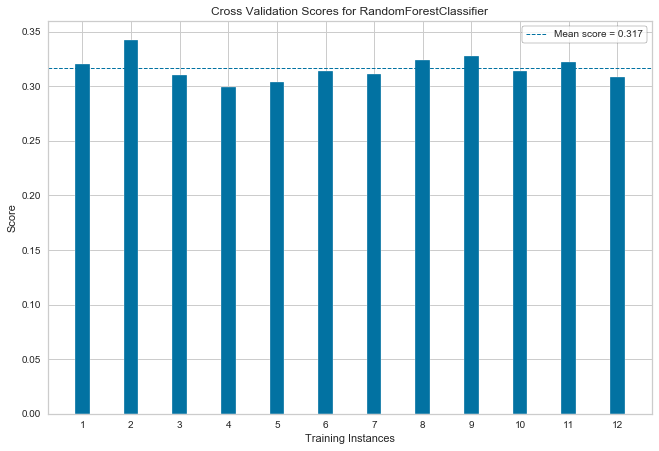

In [61]:

from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = RandomForestClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(780, 520)
)

visualizer.fit(X, y)
visualizer.show()

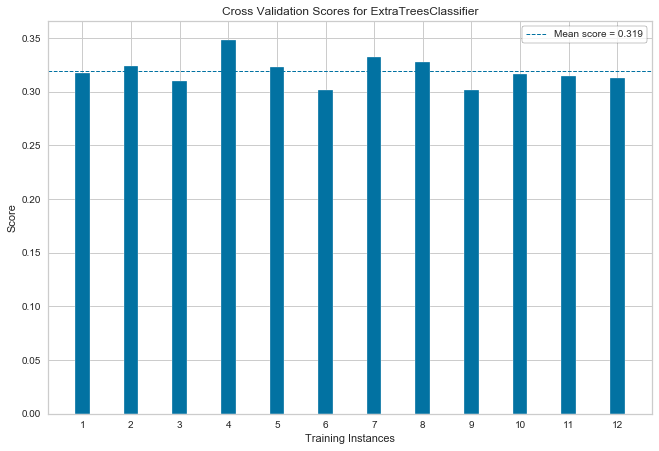

In [62]:
#With Class Balanced

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model =  ExtraTreesClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(780, 520)
)

visualizer.fit(X, y)
visualizer.show()

### GridSearchCV

In [ ]:
RandomForestClassifier().get_params()

In [ ]:

from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()

# TODO:  Create a dictionary with the Ridge parameter options
parameters = {
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_split':[2,4,6],
    'n_jobs':[2,4]
}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

print('If we change our parameters to: {}'.format(clf.best_params_))
print(clf.best_estimator_)

In [ ]:
models = [
  
    ExtraTreesClassifier(n_estimators=100, max_features='log2', n_jobs=2, random_state=42),
    AdaBoostClassifier(learning_rate=0.7,n_estimators=200),
    GradientBoostingClassifier(learning_rate=.5,max_depth=4),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, 
                        min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
  
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

In [16]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(
    RandomForestClassifier(), X, y, train_sizes=[50, 80, 110], cv=5)

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 

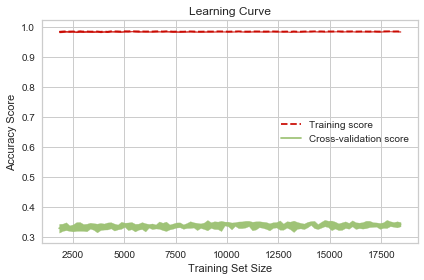

In [18]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=12,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 100))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,color="r",)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [53]:
'''
from sklearn.model_selection import validation_curve
# Create range of values for parameter
param_range = np.arange(1, 250, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)
# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="green")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
'''

'\nfrom sklearn.model_selection import validation_curve\n# Create range of values for parameter\nparam_range = np.arange(1, 250, 2)\n\n# Calculate accuracy on training and test set using range of parameter values\ntrain_scores, test_scores = validation_curve(RandomForestClassifier(), \n                                             X, \n                                             y, \n                                             param_name="n_estimators", \n                                             param_range=param_range,\n                                             cv=3, \n                                             scoring="accuracy", \n                                             n_jobs=-1)\n# Plot mean accuracy scores for training and test sets\nplt.plot(param_range, train_mean, label="Training score", color="blue")\nplt.plot(param_range, test_mean, label="Cross-validation score", color="green")\n\n# Plot accurancy bands for training and test sets\nplt.fill_between(param_range

### Different Approach - 2 Classes

In [55]:
# Labeling Rating column to 2 classes
LABEL_MAP = {
    1: "Less Satisfied",
    2: "Less Satisfied",
    3: "Less Satisfied",
    4: "Less Satisfied",
    5: "Less Satisfied",
    6: "Less Satisfied",
    7: "Less Satisfied",
    8: "Less Satisfied",
    9: "Highly Satisfied",
    10: "Highly Satisfied"
}

# Convert class labels into text
y = df['RATINGHS'].map(LABEL_MAP)
y

0        Highly Satisfied
1          Less Satisfied
2          Less Satisfied
3          Less Satisfied
4          Less Satisfied
               ...       
20103      Less Satisfied
20104      Less Satisfied
20105    Highly Satisfied
20106      Less Satisfied
20107    Highly Satisfied
Name: RATINGHS, Length: 20108, dtype: object

In [56]:
X = df[['HHAGE', 'HINCP', 'BATHROOMS', 'UTILAMT','PERPOVLVL',  'ELECAMT', 'GASAMT', 'TRASHAMT', 'WATERAMT', 'OMB13CBSA','NUMPEOPLE', 'STORIES', 'HHNATVTY']]

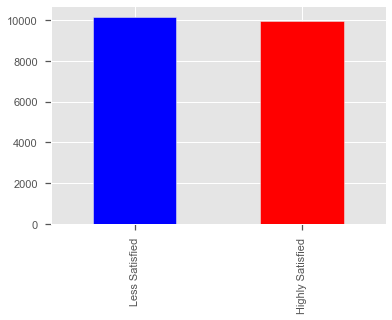

In [57]:
#identify the classes balance
pd.Series(y).value_counts().plot.bar(color=['blue', 'red'])

### Split the data into 80 to 20

In [58]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [59]:
from sklearn import metrics
def score_model(X, y, estimator, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])


    model.fit(X_train, y_train.ravel(), **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

In [60]:
from sklearn.preprocessing import LabelEncoder
# Encode our target variable

encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

y

array([0, 1, 1, ..., 0, 1, 0])

In [61]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(),
    LogisticRegression(), 
    ExtraTreesClassifier(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

SVC: 0.5074589756340129
NuSVC: 0.5333167578319244
LinearSVC: 0.5514669318746892
SGDClassifier: 0.5646444554947787
KNeighborsClassifier: 0.5435106911984088
LogisticRegression: 0.5561909497762307
ExtraTreesClassifier: 0.5549477871705619
RandomForestClassifier: 0.5537046245648931
DecisionTreeClassifier: 0.5469915464942815
AdaBoostClassifier: 0.5745897563401293
GradientBoostingClassifier: 0.5750870213823969


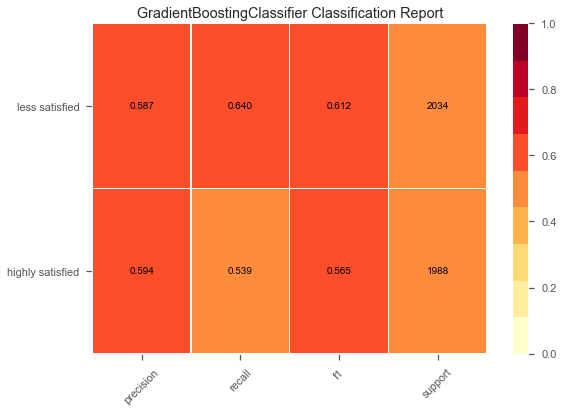

In [63]:
#Classification Report

classes=['highly satisfied', 'less satisfied']
model = GradientBoostingClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show() 

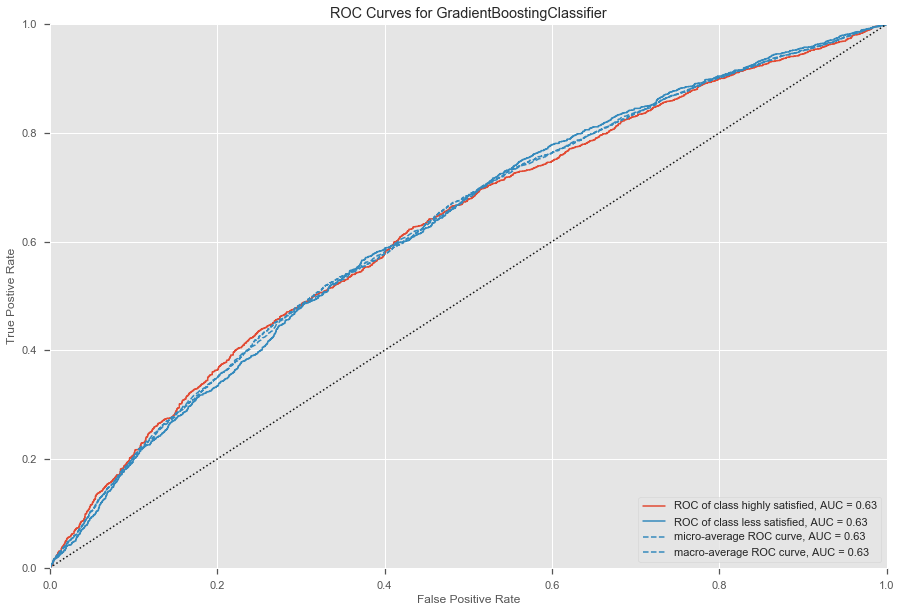

In [64]:
## ROC Curve
from yellowbrick.classifier import ROCAUC
classes=['highly satisfied', 'less satisfied']

visualizer = ROCAUC(
    GradientBoostingClassifier(), classes=classes, size=(1080, 720)
)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

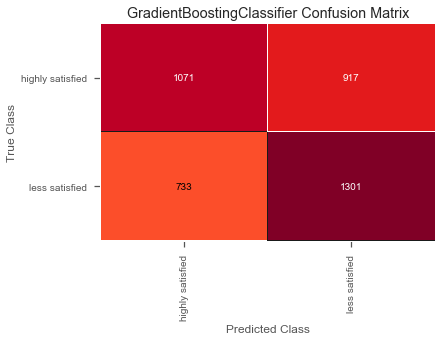

In [66]:
## Confusion Matrix

model = GradientBoostingClassifier()

cm = ConfusionMatrix(model, classes=['highly satisfied', 'less satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

In [ ]:
## GridSearch for hyperparameter tuning

from sklearn.model_selection import GridSearchCV
model = AdaBoostClassifier()

# TODO:  Create a dictionary with the Ridge parameter options
parameters = {
    'learning_rate': [1,2,3],
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [100,200,300]
}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

print('If we change our parameters to: {}'.format(clf.best_params_))
print(clf.best_estimator_)

In [67]:
models = [
  
    AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1, n_estimators=200),
    GradientBoostingClassifier(loss='exponential', max_features= 'auto',n_estimators=300),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0,      min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
  
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

AdaBoostClassifier: 0.5708602685231228
GradientBoostingClassifier: 0.5763301839880657
RandomForestClassifier: 0.5815514669318746


In [ ]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(.1, 1.0, 100))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,color="r",)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()